In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import datetime as dt
import requests
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]
import networkx as nx #graphs
cwd = os.getcwd()

import seaborn as sns
import matplotlib.pyplot as plt

local imports

In [2]:
from ExMAS.utils import inData as inData
from dotmap import DotMap
from main import make_query, parse_OTP_response
from utils import plot
from utils import get_config
from datetime import timedelta
from scipy import optimize

In [3]:
# df = pd.read_csv('georequests_O(area8,9)_D.csv').filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1) #sample
# df['treq'] = pd.to_datetime(df.treq)

dfc = pd.read_csv('demand_distribution_areaB.csv').filter(['origin_x','origin_y','destination_x', 'destination_y'], axis = 1) #demand

# dfc = pd.concat([df8, df9])

In [4]:
def PT_utility(requests, params):
    if 'walkDistance' in requests.columns:
        requests = requests
        requests['PT_fare'] = 1 + requests.transitTime * params.avg_speed/1000 * params.ticket_price
        requests['u_PT'] = requests['PT_fare'] + \
                           params.VoT * (params.walk_factor * requests.walkDistance / params.speeds.walk +
                                           params.wait_factor * requests.waitingTime +
                                           params.transfer_penalty * requests.transfers + requests.transitTime)
    return requests

OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = get_config('data/default_SUM.json')
params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 1 
params.price = 1.5

ASC = 2.5807774081294914  # ASC for (B (h1)+S)

In [ ]:
dfres = pd.DataFrame()
for i in range (3):
    df = dfc.sample(176)
    df.reset_index(drop=True, inplace=True)
    df['treq'] = pd.NA #generate of request time
    time_format = '%Y-%m-%d %H:%M:%S'
    time_lb = dt.datetime.strptime('2024-03-28 07:45:00', time_format)
    time_ub = dt.datetime.strptime('2024-03-28 08:15:00', time_format)
    df['treq'] = df['treq'].apply(lambda _: time_lb + dt.timedelta(seconds=np.random.randint(0, (time_ub - time_lb).seconds)))


    df1 = df.copy()
    df_PT_OD = df1.apply(lambda row: 
                     parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1) #query OTP for each request
    for name in list(df_PT_OD[0].keys()):
        vals = []
        for i in range(len(df_PT_OD)):
            if df_PT_OD[i]['success'] == True:
                vals.append(df_PT_OD[i][name])
            else:
                vals.append(None)
        df1[name] = vals

    reqs_PT_OD = PT_utility(df1, params)

    params = ExMAS.utils.get_config('data/default_SUM.json') # load the default
    params.city = 'Krakow, Poland'
    params = ExMAS.utils.make_paths(params) # update file paths
    inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

    def run_ExMAS_SUM(inData, params, hub, frac, repl):

        params.nP = int(frac * len(df))
        sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
        sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
        inData.requests = sample

        my_requests = inData.requests
        my_requests['destination'] = hub[1] 
        my_requests["origin"] = sample.origin.values
        my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
        my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
        my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
        my_requests['pax_id'] = list(range(len(my_requests)))

        inData.requests = my_requests
        # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
        inData = ExMAS.main(inData, params)
        schedule = inData.ExMAS.schedule
        requests = inData.ExMAS.requests

        KPIs = inData.sblts.res.to_frame()[:23]
        # KPIs['description']  = ExMAS.utils.KPIs_descriptions
        KPIs.columns = ['KPI']
        KPIs
        # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     

        return KPIs, schedule, requests

    results = dict() 
    hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.889482]))]

    for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
        for h in hubs:
            for i in range(1): 
                print(h[0], frac, i + 1)
                results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

    df_SUM = df.copy()
    df_SUM['index'] = inData.sblts.requests.index
    df_SUM['hub'] = inData.sblts.requests.destination
    df_SUM['ttrav'] = inData.sblts.requests.ttrav
    df_SUM['tarr'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav, 's').floor('s'), axis=1)
    df_SUM['u'] = inData.sblts.requests.u
    df_SUM['ttrav_sh'] = inData.sblts.requests.ttrav_sh
    df_SUM['tarr_sh'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav_sh, 's').floor('s'), axis=1)
    df_SUM['u_sh'] = inData.sblts.requests.u_sh
    # df_SUM.to_csv(f'res/ExMASrequests_OH_area10.csv')
    params.transfertime = 30 # transfertime for hub NSM-PT
    df2 = df_SUM.rename(columns = {'treq': 'treq_origin'})
    df2['origin_x'] = 19.88948 # hub1(B) coord_x
    df2['origin_y'] = 50.01844 # hub1(B) coord_y
    df2['treq'] = pd.to_datetime(df_SUM.tarr_sh) + timedelta(seconds=params.transfertime) # treq for PT

    df_PT_HD = df2.apply(lambda row: 
                     parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1)
    for name in list(df_PT_HD[0].keys()):
        vals = []
        for i in range(len(df_PT_HD)):
            if df_PT_HD[i]['success'] == True:
                vals.append(df_PT_HD[i][name])
            else:
                vals.append(None)
        df2[name] = vals
    reqs_PT_HD = PT_utility(df2, params)

    df_SUM['u_SUM_OD'] = df_SUM.u_sh + reqs_PT_HD.u_PT + ASC
    df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) / \
                         (df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) +  \
                          reqs_PT_OD.apply(lambda reqs_PT_OD: math.exp(-reqs_PT_OD.u_PT), axis=1))
    df_res= pd.DataFrame([[reqs_PT_OD.waitingTime.mean(),reqs_PT_HD.waitingTime.mean(),reqs_PT_OD.u_PT.mean(),reqs_PT_HD.u_PT.mean(), df_SUM.u_SUM_OD.mean(), df_SUM.p_SUM.mean()]], 
                             columns=list('123456')).rename(columns = {'1': 'tw_PT_OD','2': 'tw_PT_HD', '3': 'u_PT_OD', '4': 'u_PT_HD','5': 'u_SUM_OD','6': 'p_SUM' })

    dfres = dfres.append(df_res)     

    # df_res.to_csv(f'res/8_9/res.csv')

hub1 1 1
28-05-24 14:29:20-INFO-Initializing pairwise trip shareability between 176 and 176 trips.
28-05-24 14:29:20-INFO-creating combinations
28-05-24 14:29:20-INFO-30800	 nR*(nR-1)
28-05-24 14:29:45-INFO-Reduction of feasible pairs by 17.22%
28-05-24 14:29:45-INFO-Degree 2 	Completed


In [6]:
dfres.reset_index(drop=True, inplace=True)
dfres

,tw_PT_OD,tw_PT_HD,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM
0,99.589474,26.953608,14.793710,10.039672,11.581011,0.179790
1,92.248705,49.651282,14.435962,10.171308,11.656505,0.209597
2,106.350515,38.819588,14.262533,9.962347,11.636408,0.244501
3,107.963918,57.276923,14.726711,10.221448,11.838569,0.215448
4,84.644330,39.153846,13.986990,9.915385,11.547847,0.249002


## 2.4 DEMAND FOR SUM

In [ ]:
# ts = []
# for i in range(len(df_SUM)):
#     if df_SUM.p_SUM[i] > 0.5:
#         ts.append(1)
#     else:
#         ts.append(0)

In [ ]:
# df_SUM['t'] = ts 
# df_SUM.sample(3)

In [12]:
tr = []
for i in range(len(df_SUM)):
    r = random.random()
    if r < df_SUM.p_SUM[i]:
        tr.append(1)
    else:
        tr.append(0)

In [13]:
df_SUM['r'] = tr 
# df_SUM.sample(10)
demand_SUM = df_SUM[df_SUM.r == 1]
demand_PT = df_SUM[df_SUM.r != 1]


In [14]:
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.2864321608040201

In [15]:
df_SUM.p_SUM.mean()

0.2932900947870887

In [ ]:
sum(df_SUM.r)

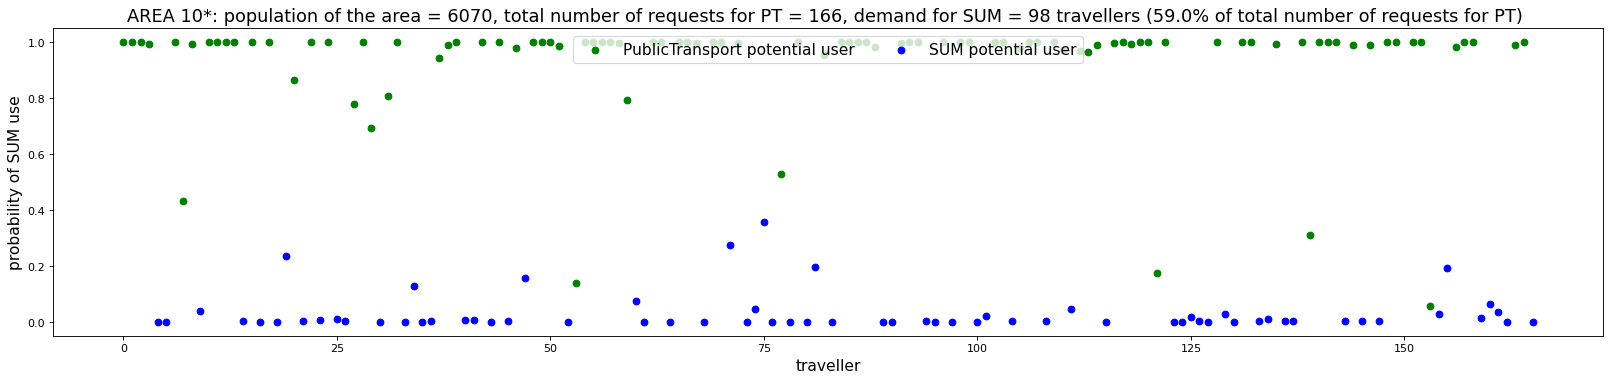

In [18]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
# plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10*: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

### * count a number of travellers with p_SUM > 0.5

In [21]:
demand_SUM = df_SUM[df_SUM.p_SUM > 0.5]  ## nested logit model
demand_PT = df_SUM[df_SUM.p_SUM < 0.5]
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.5602409638554217

In [22]:
# df_SUM[df_SUM.t != 1].to_csv(f'res/SUM chose_area10.csv')

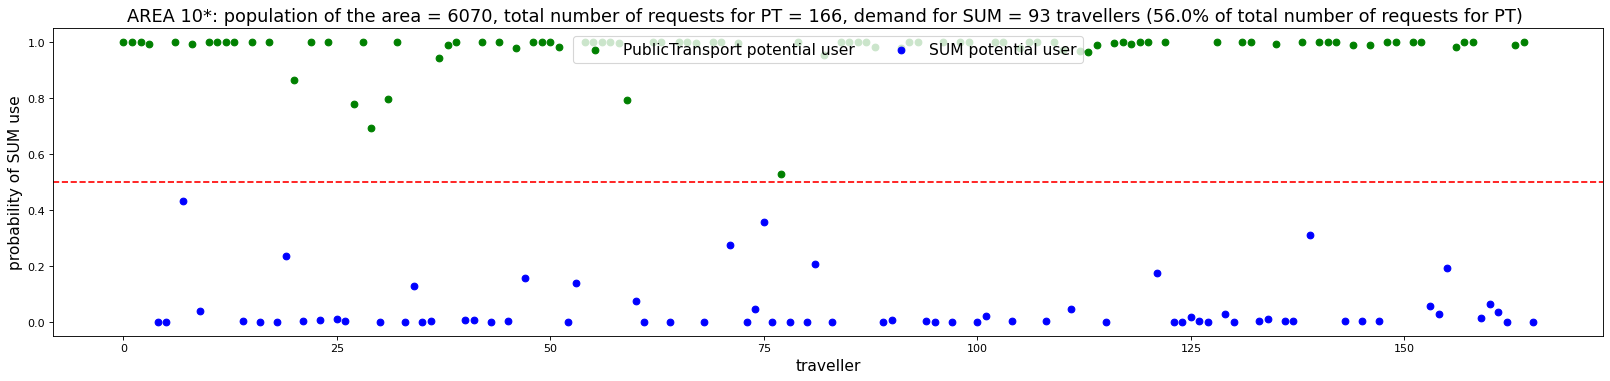

In [23]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10*: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

In [24]:
demand_SUM = df_SUM[df_SUM.p_SUM > 0.5]
demand_PT = df_SUM[df_SUM.p_SUM < 0.5]
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.5602409638554217

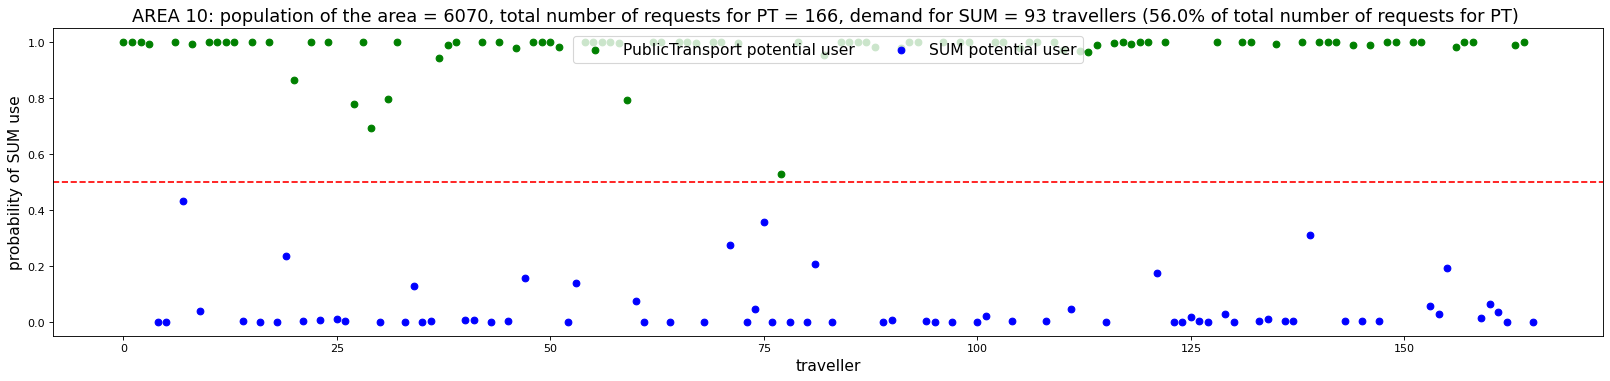

In [25]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

## ExMAS (OH) for SUM users

In [25]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    # if type(sample['treq'][0]) == str:
    #     sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.08179,19.88192]))]#

for frac in  [frac_SUM]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.2864321608040201 1
24-05-24 10:51:42-INFO-Initializing pairwise trip shareability between 57 and 57 trips.
24-05-24 10:51:42-INFO-creating combinations
24-05-24 10:51:42-INFO-3192	 nR*(nR-1)
24-05-24 10:51:43-INFO-Reduction of feasible pairs by 99.15%
24-05-24 10:51:43-INFO-Degree 2 	Completed
24-05-24 10:51:43-INFO-trips to extend at degree 2 : 58
24-05-24 10:51:43-INFO-At degree 2 feasible extensions found out of 1 searched
24-05-24 10:51:43-INFO-Degree 3 	Completed
24-05-24 10:51:43-INFO-trips to extend at degree 3 : 1
24-05-24 10:51:43-INFO-At degree 3 feasible extensions found out of 0 searched
24-05-24 10:51:43-INFO-Degree 4 	Completed
24-05-24 10:51:43-INFO-No more trips to exted at degree 4
24-05-24 10:51:43-INFO-Matching 57 trips to 116 rides in order to minimize u_veh
24-05-24 10:51:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,655 
reduced by matching to:               13,795
24-05-24 10:51:43-INFO-Calculations  completed
24-05-24 10:51:

In [ ]:
df

In [ ]:
type(df.treq[10])

## len(df)

In [112]:
results = {}
for num, frac, rep in list(itertools.product([1], [frac_SUM], range(11))):
    results[str((num, frac, rep))] = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/10/result10_(11).csv')
# dfr.head()

In [113]:
pd.read_csv('res/10/result10_(11).csv', header=None).T.to_csv('res/10/resultT10_(11).csv', header=False, index=False)

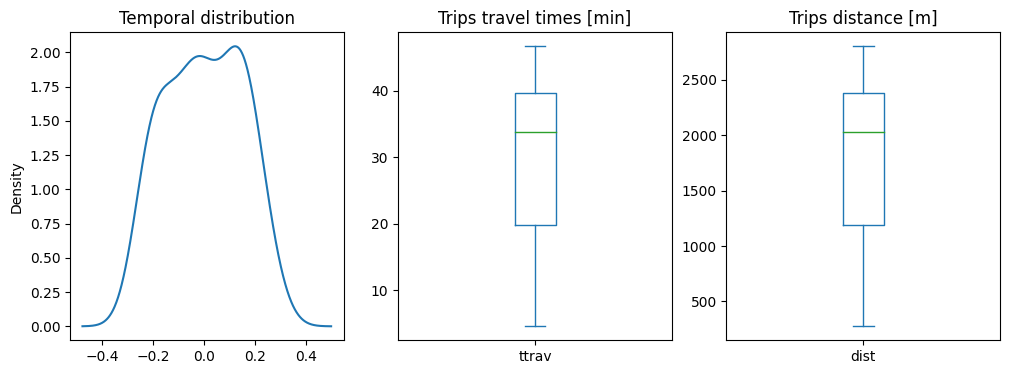

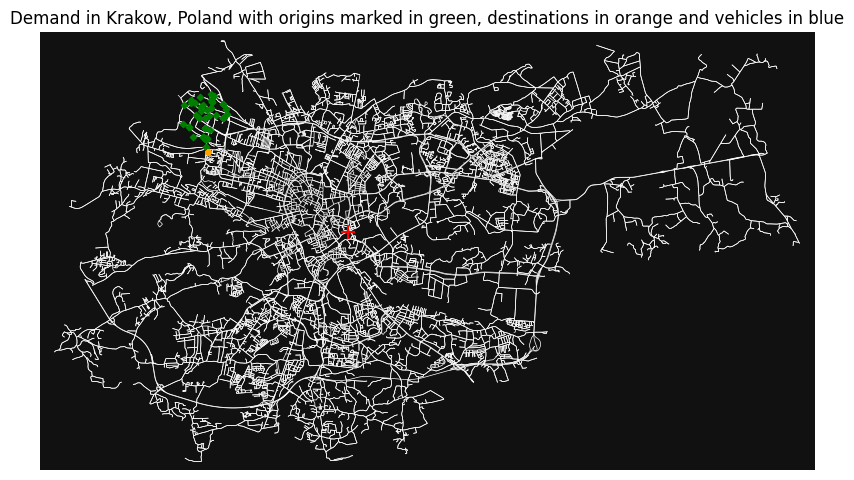

In [21]:
ExMAS.utils.plot_demand(inData, params)